In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
import os
import import_ipynb
codeDir = os.getcwd()
try:
    os.chdir('..\\Modules')
except:
    os.chdir('C:\\Users\\hydro_leo\\Documents\\GitHub\\retina_python\\Modules')
from time_shifted_PID import MIfunc
from time_shifted_PID import EqualState
from Spike_Generation import SG
from Spike_Generation import NL
os.chdir(codeDir)

importing Jupyter notebook from time_shifted_PID.ipynb
importing Jupyter notebook from Spike_Generation.ipynb


# k_fast,off (k_E) and k_slow,on (k_S)

In [3]:
def NGD_TK(T, m, n, alpha, beta, g, tau_y):
    dt = np.mean(np.diff(T))
    dt = dt/50
    T = np.arange(0, T[-1]+dt, dt)
    x = T/tau_y /tau_y *np.exp(-T/tau_y)*dt
    y = np.zeros_like(x)
    z = np.zeros_like(x)
    
    for i in range(len(T)):
        y[i] = y[i-1] + dt*(-alpha*y[i-1]+m*x[i-1]-n*z[i-1])
        z[i] = z[i-1] + dt*( -beta*z[i-1]+g*y[i-1])
    return y[:len(T):50]/dt, z[:len(T):50]/dt

In [4]:
m = 16.416565/50*100
# m = 82082.86634
n =	500
alpha = 41.464099
beta = 2.088120
g =  1729.111153/n
tau_y = 0.051583

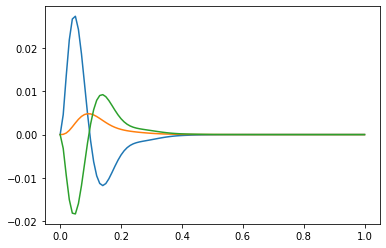

In [5]:
dt = 0.01
TKaxis = np.arange(101)*dt

psi = 0.7
k_E, k_S = NGD_TK(TKaxis, m, n, alpha, beta, g, tau_y)
k_E, k_S = k_E*dt, k_S*dt
plt.plot(TKaxis, k_E)
plt.plot(TKaxis, k_S)
plt.plot(TKaxis, -(k_E*psi-k_S*(1-psi)))

# LPOU input

In [6]:
tot = 300
Taxis = np.arange(0,tot,dt)
# OU ; input
tau = 1
D = 1
OU=np.zeros(len(Taxis))
mu, sigma = 0, 1
for i in range(len(Taxis)-1):
    OU[i+1]=OU[i]*(1-dt/tau)+np.sqrt(D*dt)*np.random.normal(mu,sigma)
# filtering for OUSmoothed
Fc = 1
b, a = signal.butter(2, 2*Fc*dt, btype='low', analog=False)
LPOU = signal.filtfilt(b, a, OU)
LPOU = (LPOU-np.mean(LPOU))/np.std(LPOU)
x = LPOU

1.3143506091224078


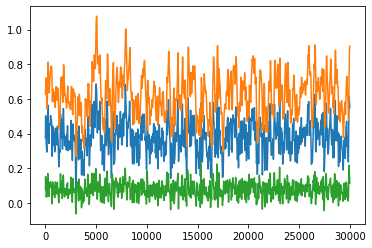

In [7]:
amp = 2
mean = 10

apapt_step = int(1/dt)
eOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,LPOU*amp+mean)), k_E, 'full')[apapt_step:apapt_step+len(LPOU)]
sOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,LPOU*amp+mean)), k_S, 'full')[apapt_step:apapt_step+len(LPOU)]
baseOutput = eOutput*psi-sOutput*(1-psi)

print(np.std(sOutput)/np.std(eOutput))
plt.plot(eOutput)
plt.plot(sOutput)
plt.plot(baseOutput)


In [8]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt

r = -baseOutput
r = NL(r, np.mean(r))
Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
baseXcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]

r = -eOutput
r = NL(r, np.mean(r))
Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
eXcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]

r = sOutput
r = NL(r, np.mean(r))
Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
sXcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]

In [9]:
state_num = 6
xstate = EqualState(LPOU, state_num)[0]

baserstate = SG(-baseOutput, dt, 0, 10, 10)
timeshift, baseMI = MIfunc(baserstate, xstate, dt, window, perSpike = True)

erstate = SG(-eOutput, dt, 0, 10, 10)
timeshift, eMI = MIfunc(erstate, xstate, dt, window, perSpike = True)

srstate = SG(sOutput, dt, 0, 10, 10)
timeshift, sMI = MIfunc(srstate, xstate, dt, window, perSpike = True)

# Subtraction + GC (Gain act on both)

In [10]:
#Gain control function
def gain_func(v):
    try: # if v is an ndarray
        v[v < 0] = 0
    except: # if v is a variable
        if v < 0 : return 1
    return 1/(1+v**4)
    
def AddGainControl(r, B, tau):
    decay = np.exp(-(np.arange(0,1,dt)+dt)/tau)
    # plt.plot(np.arange(0,1,dt)+dt,decay)

    output = np.zeros_like(r)
    gain = np.zeros_like(r)
    for i in np.arange(1,r.shape[0]):
        gain[i] = gain_func(np.sum(B*decay[:min(i,len(decay))]*output[i:max(0, i-len(decay)):-1]*dt) )
        opi = gain[i]*r[i]
        output[i] = opi
    output[output<0] = 0
    return  output, gain

In [11]:
B_e = 5000/100 #To tune altitude of gain control (D=1/T) 5000
tau_e = 0.1

B_s = 430/100 #To tune altitude of gain control (D=1/T) 380,430,480
tau_s = 0.6

# DCCM

0.05: 0.573; 0.665; 0.862
0.1: 0.576; 0.666; 0.864
0.15: 0.58; 0.669; 0.868
0.2: 0.587; 0.672; 0.874
0.3: 0.602; 0.679; 0.886


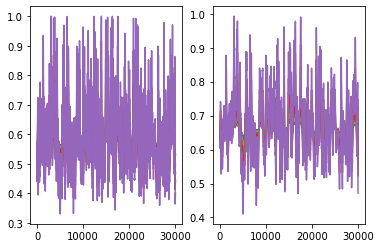

In [12]:
contrast_list = np.array([0.5,1,1.5,2,3])/mean
DCCM_output = [0]*len(contrast_list)
fig, ax = plt.subplots(1,2)
for i in range(len(contrast_list)):
    eOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,LPOU*contrast_list[i]*mean+mean)), k_E, 'full')[:apapt_step+len(LPOU)]
    sOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean,LPOU*contrast_list[i]*mean+mean)), k_S, 'full')[:apapt_step+len(LPOU)]
    eOutput, gain_e = AddGainControl(eOutput, B_e, tau_e)    
    ax[0].plot(gain_e[apapt_step:])
    sOutput, gain_s = AddGainControl(sOutput, B_s, tau_s)
    ax[1].plot(gain_s[apapt_step:]) # make sure the value of gain is good
    print(str(round(contrast_list[i], 3))+': '+str(round(np.mean(gain_e),3))+'; '+str(round(np.mean(gain_s),3))+'; '+str(round(np.mean(gain_e)/np.mean(gain_s),3)))
    DCCM_output[i] = (-eOutput[apapt_step:]*psi+sOutput[apapt_step:]*(1-psi))
    

(5000.0, 6000.0)

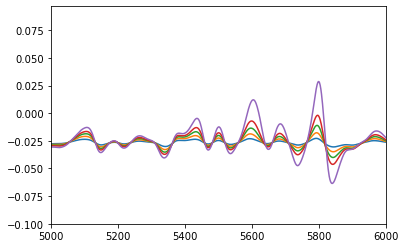

In [13]:
for i in range(len(contrast_list)):
    plt.plot(DCCM_output[i])
plt.xlim(5000,6000)

(3000.0, 6000.0)

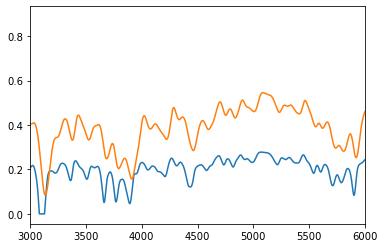

In [14]:
plt.plot(eOutput)
plt.plot(sOutput)
plt.xlim(3000,6000)

### STA

In [15]:
x = np.array(LPOU)
x = (x-np.mean(x))/np.std(x)

DCCM_Xcorr = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    r = DCCM_output[i] 
    r = NL(r, np.mean(r))
    Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    DCCM_Xcorr[i] = Xcorr.copy()

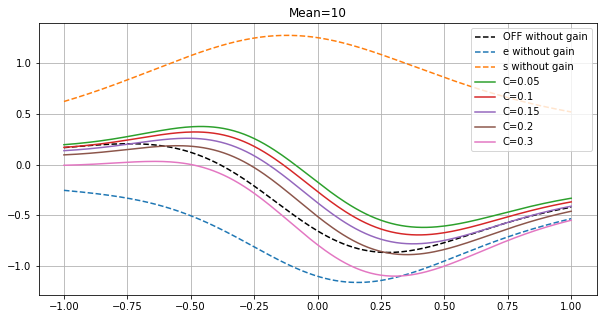

In [16]:
# plt.plot(timeaxis,baseOnXcorr, 'k--', label= 'ON without gain')
plt.plot(timeaxis,baseXcorr, 'k--',label= 'OFF without gain')
plt.plot(timeaxis,eXcorr, '--', label= 'e without gain')
plt.plot(timeaxis,sXcorr, '--', label= 's without gain')
for i in range(len(contrast_list)): 
    plt.plot(timeaxis,DCCM_Xcorr[i], label = 'C='+str(round(contrast_list[i],3)))
plt.legend()
plt.title('Mean='+str(mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

### MI

In [17]:
DCCM_rstate = [0]*len(contrast_list)
DCCM_MI = [0]*len(contrast_list)
for i in range(len(contrast_list)):
    # rstate, _ = np.histogram( Spike_Time_Generater(DCCM_output[i], dt, 10, 10), np.append(Taxis, tot))
    rstate =SG(DCCM_output[i], dt, 0, 10, 10)
    DCCM_rstate[i] = rstate.copy()
    timeshift, DCCM_MI[i] = MIfunc(rstate, xstate, dt, window, perSpike = True)

In [18]:
for rstate in DCCM_rstate:
    print(np.var(rstate), np.mean(rstate))

0.09066663888888889 0.10016666666666667
0.09034650666666665 0.0996
0.09203998222222223 0.10013333333333334
0.09389269333333333 0.0992
0.10069226555555556 0.10103333333333334


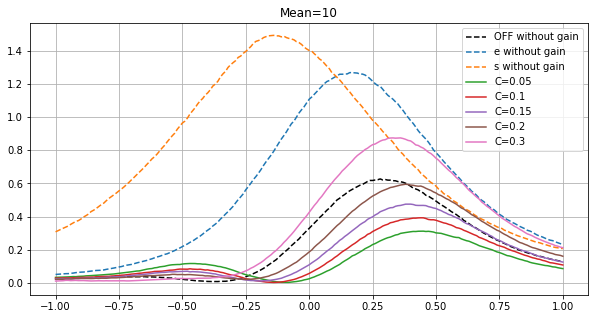

In [19]:
# plt.plot(timeaxis,baseOnMI, 'k--', label= 'ON without gain')
plt.plot(timeaxis,baseMI, 'k--', label= 'OFF without gain')
plt.plot(timeaxis,eMI, '--', label= 'e without gain')
plt.plot(timeaxis,sMI, '--', label= 's without gain')
for i in range(len(contrast_list)): 
    plt.plot(timeshift,DCCM_MI[i], label = 'C='+str(round(contrast_list[i],3)))
plt.legend()
plt.title('Mean='+str(mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

# CCDM

2: 0.986; 0.995
4: 0.892; 0.945
7: 0.715; 0.8
10: 0.587; 0.672
13: 0.498; 0.576


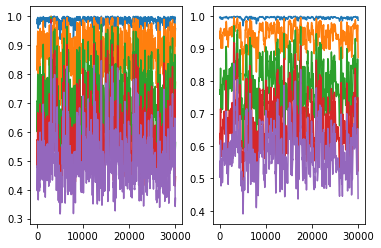

In [20]:
mag_list = [0.2,0.4,0.7,1,1.3]
# mag_list = np.linspace(0.5,100,5)
CCDM_output = [0]*len(mag_list)
fig, ax = plt.subplots(1,2)
for i in range(len(mag_list)):
    eOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean*mag_list[i],(x*amp+mean)*mag_list[i])), k_E, 'full')[:apapt_step+len(x)]
    sOutput = np.convolve( np.hstack((np.ones(apapt_step)*mean*mag_list[i],(x*amp+mean)*mag_list[i])), k_S, 'full')[:apapt_step+len(x)]
    eOutput, gain_e = AddGainControl(eOutput, B_e, tau_e)    
    ax[0].plot(gain_e[apapt_step:])
    sOutput, gain_s = AddGainControl(sOutput, B_s, tau_s)
    ax[1].plot(gain_s[apapt_step:]) # make sure the value of gain is good
    print(str(round(mag_list[i]*mean))+': '+str(round(np.mean(gain_e),3))+'; '+str(round(np.mean(gain_s),3)))
    CCDM_output[i] = -(eOutput[apapt_step:]*psi-sOutput[apapt_step:]*(1-psi))
    

(5000.0, 6000.0)

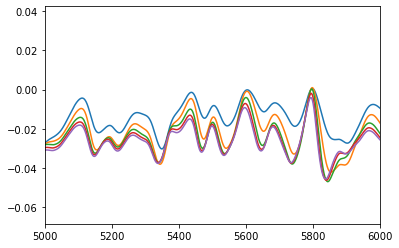

In [21]:
# plt.plot(baseOutput)
for i in range(len(mag_list)):
    plt.plot(CCDM_output[i])
plt.xlim(5000,6000)

### STA

In [22]:
window = [-1,1] # second
timeaxis = np.arange(-100,101)*dt

x = np.array(LPOU)
x = (x-np.mean(x))/np.std(x)

CCDM_Xcorr = [0]*len(mag_list)
for i in range(len(mag_list)):
    r = CCDM_output[i] 
    r = NL(r, np.mean(r))
    Xcorr = np.correlate(x, r, 'same') / np.correlate(np.ones_like(x), r, 'same')
    Xcorr = Xcorr[int(len(Xcorr)/2)-100 : int(len(Xcorr)/2)+101]
    CCDM_Xcorr[i] = Xcorr.copy()

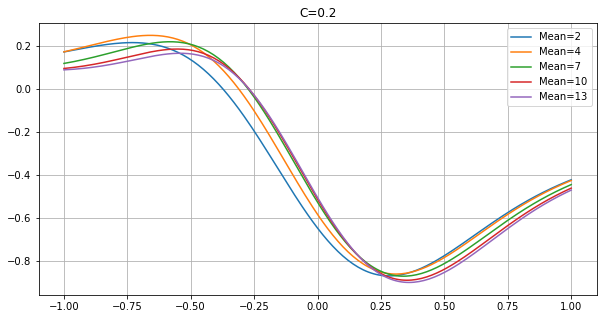

In [23]:
# plt.plot(timeaxis,baseXcorr, 'k--', label= 'without gain')
for i in range(len(mag_list)): 
    plt.plot(timeaxis,CCDM_Xcorr[i], label = 'Mean='+str(round(mag_list[i]*mean)))
plt.legend()
plt.title('C='+str(amp/mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

### MI

In [24]:
CCDM_MI = [0]*len(mag_list)
CCDM_rstate = [0]*len(mag_list)
for i in range(len(mag_list)):
    CCDM_rstate[i] =SG(CCDM_output[i], dt, 0, 10, 10)
    timeshift, CCDM_MI[i] = MIfunc(CCDM_rstate[i], xstate, dt, window, perSpike = True)

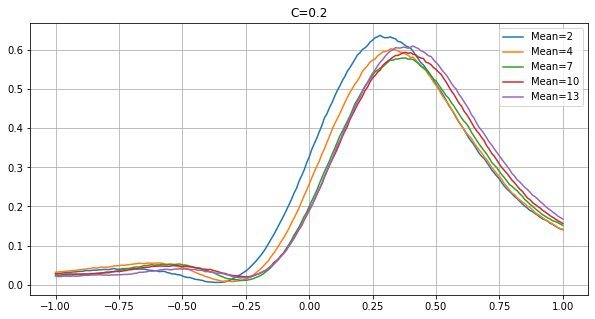

In [25]:
# plt.plot(timeaxis,baseMI, 'k--', label= 'without gain' )
for i in range(len(mag_list)): 
    plt.plot(timeaxis,CCDM_MI[i], label = 'Mean='+str(round(mag_list[i]*mean)))
plt.legend()
plt.title('C='+str(amp/mean))
plt.grid('on')
plt.gcf().set_size_inches(10,5)

# Saving Data

In [26]:
name = 'model-typeA'

legend = ['M=10;C='+str(C) for C in [0.05,0.1,1.5,0.2,0.3]]+['C=0.2;M='+str(M) for M in [2,4,7,10,13]]

In [27]:
MI_Data = {}
STA_Data = {}
MI_Data['timeshift'] = timeaxis
STA_Data['timeshift'] = timeaxis

i=0
for MI in DCCM_MI:
    MI_Data[legend[i]] = MI
    i += 1
for MI in CCDM_MI:
    MI_Data[legend[i]] = MI
    i += 1
    
i=0
for Xcorr in DCCM_Xcorr:
    STA_Data[legend[i]] = Xcorr
    i += 1
for Xcorr in CCDM_Xcorr:
    STA_Data[legend[i]] = Xcorr
    i += 1
    

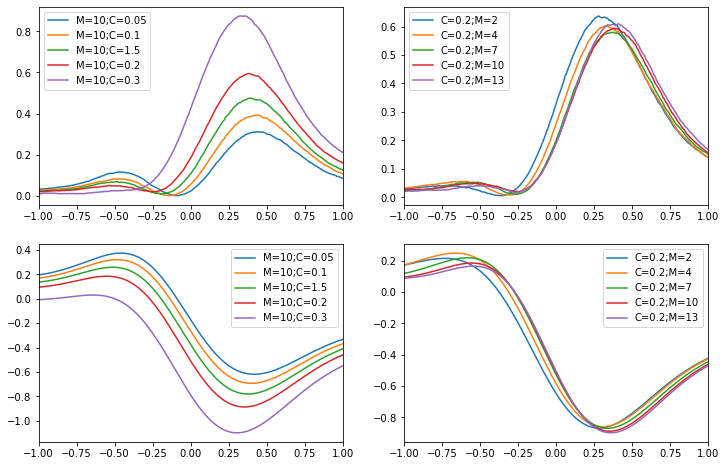

In [28]:
fig, ax = plt.subplots(2,2)
cmind=0
for i in range(5):
    ax[0,0].plot(MI_Data['timeshift'], MI_Data[legend[i]], label = legend[i], color = plt.cm.tab10(cmind))
    ax[1,0].plot(MI_Data['timeshift'], STA_Data[legend[i]], label = legend[i], color = plt.cm.tab10(cmind))
    cmind += 1
cmind=0
for i in np.arange(5,10):
    ax[0,1].plot(MI_Data['timeshift'], MI_Data[legend[i]], label = legend[i], color = plt.cm.tab10(cmind))
    ax[1,1].plot(MI_Data['timeshift'], STA_Data[legend[i]], label = legend[i], color = plt.cm.tab10(cmind))
    cmind += 1


for axi in ax.flatten():
    axi.legend()
    axi.set_xlim([-1,1])
fig.set_size_inches(12, 8)

In [29]:
# MI_data_df = pd.DataFrame(MI_Data)
# STA_data_df = pd.DataFrame(STA_Data)
# with pd.ExcelWriter(name+'.xlsx') as writer:
#     MI_data_df.to_excel(writer,'MI',float_format='%.6f') # float_format 控制精度
#     STA_data_df.to_excel(writer,'STA',float_format='%.6f') # float_format 控制精度